### Importing libraries

In [1]:
import numpy as np
import pandas as pd
from linearmodels import PooledOLS
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Loading the data

In [2]:
data_path = "data/Retail_Sales_Data.csv"
df = pd.read_csv(data_path)
df.head()

,retailer,store_id,week,product,description,regular_price,competition_1_regular_price,competition_2_regular_price,competition_3_regular_price,competition_4_regular_price,...,competition_4_promo_price,competition_5_promo_price,competition_6_promo_price,competition_7_promo_price,competition_8_promo_price,competition_9_promo_price,competition_10_promo_price,value,volume,quantity
0,retail1,1,1,MintyFresh Mint 18g,MintyFresh refresh mint 18grams,10.308645,10.624815,10.013451,10.378847,9.910385,...,8.500521,7.139537,7.606831,8.339536,7.184384,5.759620,7.376553,85.368310,3.953882,9.707949
1,retail1,1,1,ChocoDelight Dark 200g,200g ChocoDelight smooth,7.947956,7.748726,7.589198,8.085262,7.602363,...,5.766135,4.267236,5.912718,5.156558,6.976287,5.884786,5.335849,82.924731,2.991418,14.922586
2,retail1,1,1,ChocoDelight White 350g,350g ChocoDelight delicious,13.439368,13.751508,13.183621,13.875440,12.982707,...,8.195118,8.214548,8.995387,10.266603,10.940801,8.727031,7.915147,52.527762,6.513600,12.889607
3,retail1,1,1,NuttyCream Hazelnuts 80g,delightful Hazelnuts 80g NuttyCream,5.112777,5.279713,5.222118,5.117789,4.877549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.373782,5.489587,14.374834
4,retail1,1,1,DarkDream Dark 60g,A decadent DarkDream dark chocolate ice cream ...,14.085425,14.153721,13.860002,14.339698,14.365517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.718252,9.152050,9.193818


### Principal Component Analysis

In [3]:
# Separating the features
features = ['regular_price', 'competition_1_regular_price', 'competition_2_regular_price',
            'competition_3_regular_price', 'competition_4_regular_price',
            'competition_5_regular_price', 'competition_6_regular_price',
            'competition_7_regular_price', 'competition_8_regular_price',
            'competition_9_regular_price', 'competition_10_regular_price',
            'value', 'volume']
X = df[features]  # Select the relevant features

# Standardising the data for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Performing PCA
pca = PCA(n_components=5)  # Choose the number of principal components
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance: {explained_variance}')

Explained variance: [8.40679938e-01 7.77983954e-02 7.60459233e-02 6.33187075e-04
 6.24865177e-04]


The first 3 features explain around 99% of the variance. They are the best features to be used for the pooled model.

In [4]:
# Transforming data
X_transformed = pca.transform(X_scaled)

df_pca = pd.DataFrame(X_transformed, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
print(df_pca)

           PC1       PC2       PC3       PC4       PC5
0    -1.670053 -1.245862 -0.389645 -0.053615 -0.032008
1    -3.535361 -1.443016 -0.062472  0.049256  0.014104
2     0.784019  0.351601 -0.190630  0.047688  0.022422
3    -5.661649  0.184705  0.192050  0.033847 -0.034028
4     1.305873  1.205487 -0.781519  0.018982  0.057910
...        ...       ...       ...       ...       ...
8835 -5.314883  0.408000  0.948659 -0.050536 -0.047901
8836  2.965257 -1.097478  0.989325 -0.275277  0.173898
8837  1.944548  1.502313 -0.437902  0.050442 -0.096012
8838 -5.095377 -1.431782  0.342443  0.050491 -0.070063
8839  3.900398 -0.423406  0.003379 -0.115279  0.022554

[8840 rows x 5 columns]


In [5]:
loadings = pca.components_
df_loadings = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=features)

In [6]:
# Getingt the absolute values of the loadings
df_loadings_abs = df_loadings.abs()

# Sorting each column individually
df_sorted_loadings = df_loadings_abs.apply(lambda col: col.sort_values(ascending=False).head(3))

# Print the sorted loadings
print(df_sorted_loadings)

                                  PC1       PC2       PC3       PC4       PC5
competition_2_regular_price  0.301436       NaN       NaN  0.370785  0.274171
competition_3_regular_price       NaN       NaN       NaN       NaN  0.742740
competition_5_regular_price       NaN  0.001024       NaN  0.660941       NaN
competition_6_regular_price       NaN       NaN       NaN  0.323932       NaN
competition_8_regular_price       NaN       NaN       NaN       NaN  0.528770
competition_9_regular_price  0.301440       NaN  0.001210       NaN       NaN
regular_price                0.302395       NaN       NaN       NaN       NaN
value                             NaN  0.707134  0.707077       NaN       NaN
volume                            NaN  0.707077  0.707133       NaN       NaN


From the Principal component analysis, it is clear that regular_price, value and volume are the three features that have the highest impact on each principal component

### Using Feature Engineering

In [7]:
# Filter data for Retailer1
df_retail1 = df[df['retailer'] == 'retail1']

week = pd.Categorical(df_retail1.week)
df_retail1 = df_retail1.set_index(["store_id", "week"])
df_retail1["week"] = week

In [8]:
competitor_prices = [f'competition_{i}_regular_price' for i in range(1, 11)]
df_retail1['average_competitor_price'] = df_retail1[competitor_prices].mean(axis=1)

In [9]:
X = df_retail1[['regular_price', 'average_competitor_price',  'value', 'volume']]
y = df_retail1['quantity']

In [10]:
vif_values = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif = pd.DataFrame({'Features': X.columns, 'VIF': vif_values})
vif

,Features,VIF
0,regular_price,12479.941256
1,average_competitor_price,12482.562367
2,value,4.177858
3,volume,4.204079


In [11]:
# Add a constant to the features (intercept term)
X = sm.add_constant(X)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Create the Pooled OLS model
pooled_model = PooledOLS(y_train, X_train)

# Fit the model
pooled_results = pooled_model.fit()

# Print model summary to inspect coefficients and statistics
print(pooled_results.summary)

                          PooledOLS Estimation Summary                          
Dep. Variable:               quantity   R-squared:                        0.4629
Estimator:                  PooledOLS   R-squared (Between):              0.2717
No. Observations:                4160   R-squared (Within):               0.4638
Date:                Tue, Oct 29 2024   R-squared (Overall):              0.4629
Time:                        12:37:57   Log-likelihood                -1.029e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      895.40
Entities:                          10   P-value                           0.0000
Avg Obs:                       416.00   Distribution:                  F(4,4155)
Min Obs:                       404.00                                           
Max Obs:                       429.00   F-statistic (robust):             895.40
                            

In [13]:
y_pred = pooled_results.predict(X_test)

# Step 7: Model Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nPooled OLS Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")


Pooled OLS Model Performance on Test Set:
Mean Squared Error (MSE): 8.367306476666839
Mean Absolute Error (MAE): 2.5196007831506924
R-squared: 0.4992482409207004


### Using columns from PCA

In [14]:
# Filter data for Retailer1
df_retail1 = df[df['retailer'] == 'retail1']

week = pd.Categorical(df_retail1.week)
df_retail1 = df_retail1.set_index(["store_id", "week"])
df_retail1["week"] = week


X = df_retail1[['regular_price',  'value', 'volume']]
y = df_retail1['quantity']

In [15]:
vif_values = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif = pd.DataFrame({'Features': X.columns, 'VIF': vif_values})
vif

,Features,VIF
0,regular_price,5.164766
1,value,4.177858
2,volume,4.202805


In [16]:
# Add a constant to the features (intercept term)
X = sm.add_constant(X)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create the Pooled OLS model
pooled_model = PooledOLS(y_train, X_train)

# Fit the model
pooled_results = pooled_model.fit()

# Print model summary to inspect coefficients and statistics
print(pooled_results.summary)

                          PooledOLS Estimation Summary                          
Dep. Variable:               quantity   R-squared:                        0.4627
Estimator:                  PooledOLS   R-squared (Between):              0.2692
No. Observations:                4160   R-squared (Within):               0.4636
Date:                Tue, Oct 29 2024   R-squared (Overall):              0.4627
Time:                        12:37:57   Log-likelihood                -1.029e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1192.9
Entities:                          10   P-value                           0.0000
Avg Obs:                       416.00   Distribution:                  F(3,4156)
Min Obs:                       404.00                                           
Max Obs:                       429.00   F-statistic (robust):             1192.9
                            

In [17]:
y_pred = pooled_results.predict(X_test)

# Step 7: Model Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nPooled OLS Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")


Pooled OLS Model Performance on Test Set:
Mean Squared Error (MSE): 8.36628292511887
Mean Absolute Error (MAE): 2.5189799732365414
R-squared: 0.4993094966234266


In [18]:
pooled_results.params.values

array([ 4.89162135, -0.03719734,  0.10207052,  0.1855003 ])

In [19]:
pooled_results.params

const            4.891621
regular_price   -0.037197
value            0.102071
volume           0.185500
Name: parameter, dtype: float64

In [20]:
pooled_results.resids.std()

2.8731253225417834

In [21]:
y_test

store_id  week
3         18       7.838230
1         16      11.716301
7         29      18.773129
4         36       9.924088
9         74      11.392241
                    ...    
3         28       7.221941
2         82      11.611357
9         9        9.573949
1         10      11.466816
4         34      17.639147
Name: quantity, Length: 1040, dtype: float64

In [22]:
y_pred

,,predictions
store_id,week,
3,18,10.223133
1,16,9.648528
7,29,14.875927
4,36,9.626612
9,74,7.923685
...,...,...
3,28,8.451582
2,82,9.392526
9,9,12.331239


In [23]:
pred_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred.predictions.tolist()})
pred_df.head(10)

,Actual,Predicted
0,7.838230,10.223133
1,11.716301,9.648528
2,18.773129,14.875927
3,9.924088,9.626612
4,11.392241,7.923685
5,11.707034,13.182898
6,10.102846,7.513246
7,6.829288,7.571338
8,14.465913,15.067593
9,7.641243,10.385240


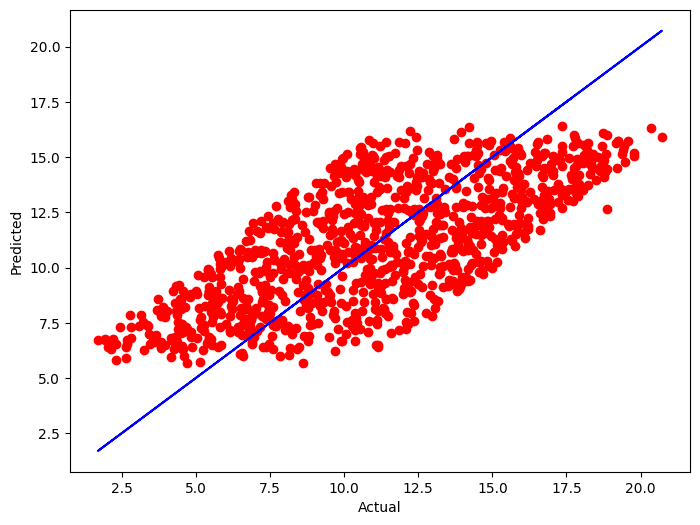

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(x=y_test.values, y=y_pred.predictions, color='r')
plt.plot(y_test, y_test, color='b')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()